<a href="https://colab.research.google.com/github/insightcampus/202008-youth-bigdata/blob/master/hnjoo/sentiment_analysis/S.A_3_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝을 이용한 자연어 처리
- 참조1. https://wikidocs.net/32105
- 참조2. https://dschloe.github.io/python/tensorflow2.0/ch7_3_sentimentanalysis/

## [감성분석 실습3] 네이버 영화리뷰 감성분석: 딥러닝을 위한 전처리 RNN

### 0. 준비하기
- 텐서플로우 실행하기(in jupyter notebook)
  + tensorflow 2.0 설치: terminal에 명령 3개 입력
    + Requires the latest pip
      + pip install --upgrade pip
    + Current stable release for CPU and GPU
      + pip install tensorflow
    + Or try the preview build(unstable)
      + pip install tf-nightly
  + 필요한 패키지 불러오기
    + %matplotlib inline
    + import matplotlib.pyplot as plt
    + from tensorflow.keras.preprocessing.text import Tokenizer
    + from tensorflow.keras.preprocessing.sequence import pad_sequences

- 텐서플로우 실행하기(in colab)
  + 텐서플로우 불러오기
  + 한글형태소분석기 설치하기
  + 구글 드라이브 연동하기

In [1]:
# 텐서플로우 실행 시 필수 코드
%tensorflow_version 2.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# 코렙 mecab 설치 
!sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
# !sudo apt-get install python-dev; pip install konlpy     # Python 2.x
!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package openjdk-7-jdk is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'openjdk-7-jdk' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.6.7-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 9.3MB/s 
     |████████████████████████████████| 3.8MB 43.2MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4

In [4]:
from konlpy.tag import Mecab
m = Mecab()
m.nouns('메캡이 잘 실행 될까요?')

['메', '캡', '실행']

In [5]:
# 구글 드라이브 연동하기
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wENxxM5hnnLSqeatGaVkMszVUI6eb2ibk_n1FohG3-CiQpx7UnI1No
Mounted at /content/gdrive


In [6]:
%cd '/content/gdrive/My Drive/전송/movie_reviews'

/content/gdrive/My Drive/전송/movie_reviews


In [7]:
%ls

ratings_test.txt  ratings_train.txt


### 1. 네이버 영화리뷰 데이터 가져오기
- 데이터 다운로드 링크 : https://github.com/e9t/nsmc
- 데이터 읽기:
    + 탭으로 구분되어 있는 텍스트 파일 > 구분기호를 의미하는 sep를 \t
    + 열의 갯수가 총 3개라 quoting=3


In [8]:
import pandas as pd
import numpy as np
# read train_data and test_data
train_df = pd.DataFrame(pd.read_csv('ratings_train.txt', sep='\t', quoting=3))
train_df = train_df.replace(np.nan, '', regex=True)
test_df = pd.DataFrame(pd.read_csv('ratings_test.txt', sep='\t', quoting=3))
test_df = test_df.replace(np.nan, '', regex=True)   # 결측치는 공백으로 처리
print('train :',len(train_df))
print('test :', len(test_df))

train : 150000
test : 50000


In [ ]:
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2. 데이터 전처리와 토큰화
- 이모티콘, 영문, 숫자, ... 삭제
- stopword, stoppos, 1글자 제거

In [9]:
import re   # 정규표현 사용 시 필요한 패키지

# '한글'을 제외한 다른 문자 모두 제거하는 함수
remove_except_ko = re.compile(r"[^가-힣ㄱ-하-ㅣ\\s]")
def preprocess(text):
  text = re.sub(remove_except_ko,' ',text).strip()
  return text

train_df['document'] = train_df['document'].map(lambda x : preprocess(x))
test_df['document'] = test_df['document'].map(lambda x : preprocess(x))  # x는 document 해당하는 로우 하나하나
# for문 대신 사용 > 실행속도 빨라짐

In [ ]:
train_df.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
from konlpy.tag import Mecab
mecab = Mecab()
# mecab을 사용해서 토큰화, 한글자 제거, stop_word 제거
stop_word = ['께서','에서','이다','에게','으로','이랑','까지','부터','하다']
stopPos = 'JKS JKC JKG JKO JKB JKY JKQ JC JX SF SE SS SP SSO SSC SC SY SH SL SN MM MAG MAJ'.split()

def postagging_mecab(text):
  text = mecab.morphs(text)
  text = [i for i in text if len(i)>1]
  text = [i for i in text if i[0] not in stop_word]
  # text = [i[0] for i in text if i[1] not in stopPos]
  return text

In [11]:
token = postagging_mecab(train_df['document'][1])
token

['포스터', '보고', '초딩', '영화', '오버', '연기', '조차', '가볍', '구나']

In [12]:
# 토큰화 + 토큰리스트 생성
def make_tokens(df):
  df['tokens'] = ''
  tokens_list = []
  for i, row in df.iterrows():
    if i%10000==0:
      print(i, '/', len(df))
    token = postagging_mecab(df['document'][i])
    tokens_list.append(token)
    df['tokens'][i] = token
  return tokens_list, df

In [13]:
train_list,train_df = make_tokens(train_df)
test_list,test_df = make_tokens(test_df)

0 / 150000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


10000 / 150000
20000 / 150000
30000 / 150000
40000 / 150000
50000 / 150000
60000 / 150000
70000 / 150000
80000 / 150000
90000 / 150000
100000 / 150000
110000 / 150000
120000 / 150000
130000 / 150000
140000 / 150000
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000


In [15]:
train_df.head()

,id,document,label,tokens
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[진짜, 짜증, 네요, 목소리]"
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1,"[포스터, 보고, 초딩, 영화, 오버, 연기, 조차, 가볍, 구나]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너무, 밓었다그래서보는것을추천한다]"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0,"[교도소, 이야기, 구먼, 솔직히, 재미, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[사이몬페그, 익살, 스런, 연기, 돋보였, 영화, 스파이더맨, 에서, 보이, 커스..."


### 3. RNN 모델을 학습시킬 수 있는 형태로 변경하기

1) 토큰화된 단어 벡터화
  - Tokenizer ref. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

2) 패딩(padding)
  - 네트워크에 입력하려면 데이터의 크기(문장 길이) 동일해야 함
  - 긴 문장 줄이고, 짧은 문장 padding 채우기
  - pad_sequences ref. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
# 선언
tokenizer = Tokenizer()

# make train word set: 각각의 단어별로 index(숫자) 부여
tokenizer.fit_on_texts(train_list)

# 4만 6979개의 word set 
# print(tokenizer.word_index)

In [19]:
# 한글단어 > 숫자배열(with index)로 변환
X_train_arrary_list = tokenizer.texts_to_sequences(train_list)
X_test_arrary_list = tokenizer.texts_to_sequences(test_list)
X_train = X_train_arrary_list
X_test = X_test_arrary_list

# 레이블링 데이터 행렬변환
Y_train = np.array(train_df['label'])  # 학습을 위한 정답 데이터(Y) 만들기
Y_test = np.array(test_df['label'])  # np.array로 변환해주기
print('훈련데이터 : ',len(X_train_arrary_list))

훈련데이터 :  150000


In [22]:
print(train_list[:2])
print(X_train[:2])

[['진짜', '짜증', '네요', '목소리'], ['포스터', '보고', '초딩', '영화', '오버', '연기', '조차', '가볍', '구나']]
[[9, 110, 6, 455], [300, 310, 417, 1, 1133, 12, 581, 642, 212]]


리뷰의 최대 길이 : 65
리뷰의 평균 길이 : 7.5836733333333335


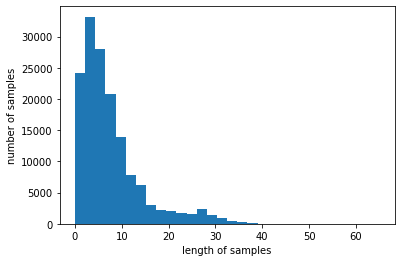

In [24]:
# padding (패딩) : 길이 맞추기
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

plt.hist([len(s) for s in X_train], bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 98.78133333333334


In [26]:
# 데이터 길이 30으로 패딩 
max_len = 30
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [27]:
len(X_train)

150000

### 5. LSTM을 사용한 감성분석

In [29]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
vocab_size = len(X_train)
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))        # LSTM(100) 했으면 Dense(128) 해줘야 함
model.add(Dense(128, activation='relu'))  
model.add(Dense(1, activation='sigmoid'))   # 이건 결과값으로 받을 것

In [31]:
# Early Stopping : 검증 데이터 손실(val_loss)이 증가 > 과적합이 될수 있기 때문에 검증 데이터 손실이 4회 증가하면 학습을 조기 종료 
# ModelCheckpoint : 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
# 학습 이전에 확인할 것(행 수, 데이터타입 비교)
# Tensorflow는 기본적으로 행렬(텍스트x, 숫자o)
print(X_train.shape)
print(Y_train.shape)
print(type(X_train))
print(type(Y_train))

((150000, 63), (150000,))

In [32]:
# generate model 
# loss = 'sparse_categorical_crossentropy' # 분류모델사용 
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, epochs=15, callbacks=[es, mc], 
                    batch_size=60, validation_split=0.2)

  # fit: 모델이 데이터에 적합해가는 과정
  # batch_size: 한 번에 학습시킬 데이터 양
  # epochs: 총 훈련 횟수를 의미 ( 5번 훑는 것은 epochs = 5 )
  # validation_split: 훈련 데이터의 20%를 검증 데이터로 사용

Epoch 1/15
2000/2000 [==============================] - ETA: 0s - loss: 0.4273 - acc: 0.7948
Epoch 00001: val_acc improved from -inf to 0.80933, saving model to 
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: assets
2000/2000 [==============================] - 290s 145ms/step - loss: 0.4273 - acc: 0.7948 - val_loss: 0.4014 - val_acc: 0.8093
Epoch 2/15
2000/2000 [==============================] - ETA: 0s - loss: 0.3700 - acc: 0.8311
Epoch 00002: val_acc improved from 0.80933 to 0.82260, saving model to 
INFO:tensorflow:Assets written to: assets
2000/2000 [==============================] - 287s 144ms/step - loss: 0.3700 - acc: 0.8311 - val_loss: 0.3808 - val_acc: 0.8226
Epoch 3/15
2000/2000 [==============================] - ETA: 0s - loss: 0.3401 - acc: 0.8497
Epoch 00

### 6. 학습된 모델로 test 데이터 예측

In [33]:
loaded_model = load_model('')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, Y_test)[1]))

1563/1563 [==============================] - 18s 12ms/step - loss: 0.3814 - acc: 0.8243

 테스트 정확도: 0.8243


In [34]:
def predict_pos_text(text):
    token=[]
    tokens = postagging_mecab(text) 
    token.append(tokens)
    print(token)
    X_train_arrary_list = tokenizer.texts_to_sequences(token)
    max_len=30
    X_train = pad_sequences(X_train_arrary_list, maxlen = max_len)
    score = float(loaded_model.predict(X_train))
    print('score:', type(score))
    if score>0.5:
        print("[{}]는 {:.2f}% 확률로 긍정 리뷰입니다.\n".format(text, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 부정 리뷰입니다.\n".format(text, (1 - score) * 100))

In [35]:
predict_pos_text('3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??')

[['아니', '어도', '다섯', '텐데', '나와서', '심기', '불편']]
score: <class 'float'>
[3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??]는 95.17% 확률로 부정 리뷰입니다.



In [36]:
predict_pos_text('영화 너무 재미있어요! 아이랑 잘 봤습니다')

[['영화', '너무', '재미있', '어요', '아이', '습니다']]
score: <class 'float'>
[영화 너무 재미있어요! 아이랑 잘 봤습니다]는 97.49% 확률로 긍정 리뷰입니다.



In [37]:
predict_pos_text('발연기 도저히 못보겠다 진짜 이렇게 연기를 못할거라곤 상상도 못했네')

[['발연기', '도저히', '진짜', '이렇게', '연기', '라곤', '상상', '못했']]
score: <class 'float'>
[발연기 도저히 못보겠다 진짜 이렇게 연기를 못할거라곤 상상도 못했네]는 99.24% 확률로 부정 리뷰입니다.



In [38]:
predict_pos_text('담백하고 깔끔해서 좋다. 신문기사로만 보다 보면 자꾸 잊어버린다. 그들도 사람이었다는 것을')

[['담백', '깔끔', '해서', '신문', '기사', '보다', '자꾸', '잊어버린다', '사람', '다는']]
score: <class 'float'>
[담백하고 깔끔해서 좋다. 신문기사로만 보다 보면 자꾸 잊어버린다. 그들도 사람이었다는 것을]는 74.98% 확률로 긍정 리뷰입니다.



In [39]:
predict_pos_text('이영화는 명작이다. 사회적 모순을 모두 담은 영화였다 조디 포스터는 더 마초적인 모습으로 과거의 아픔을 숨기며 성공에 이를 악물고 살며 닥터 랙터와 이야기를 나누며 서로는 약간의 동질감을 느꼈을 수도 있다.')

[['영화', '명작', '사회', '모순', '모두', '영화', '조디', '포스터', '마초', '모습', '으로', '과거', '아픔', '숨기', '성공', '악물', '닥터', '이야기', '나누', '서로', '약간', '동질감', '느꼈']]
score: <class 'float'>
[이영화는 명작이다. 사회적 모순을 모두 담은 영화였다 조디 포스터는 더 마초적인 모습으로 과거의 아픔을 숨기며 성공에 이를 악물고 살며 닥터 랙터와 이야기를 나누며 서로는 약간의 동질감을 느꼈을 수도 있다.]는 98.19% 확률로 긍정 리뷰입니다.



In [40]:
predict_pos_text('강력한 몰입감을 선사하는 두 배우의 연기력!! 오랜만에 정말 색다른 영화였다')

[['강력', '입감', '선사', '배우', '연기력', '오랜만', '정말', '색다른', '영화']]
score: <class 'float'>
[강력한 몰입감을 선사하는 두 배우의 연기력!! 오랜만에 정말 색다른 영화였다]는 97.27% 확률로 긍정 리뷰입니다.



In [41]:
predict_pos_text('재밌을 줄 알았는데 대박 별로에요')

[['재밌', '는데', '대박', '별로', '에요']]
score: <class 'float'>
[재밌을 줄 알았는데 대박 별로에요]는 77.21% 확률로 부정 리뷰입니다.

